In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading the dataset

In [ ]:
train_df =  pd.read_csv('/content/drive/MyDrive/NLP/sentiment_analysis/train.tsv',sep="\t")
train_df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


basic info on the dataset

>The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [ ]:
train_df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


# Basic EDA

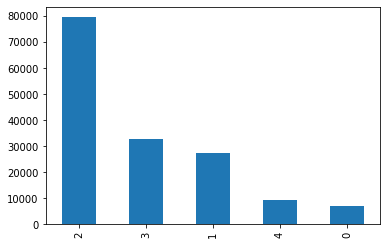

In [ ]:
train_df['Sentiment'].value_counts().plot.bar()

Most people have `neutral` response

looking at random review phrases

In [ ]:
import random
random_review = random.choice(range(0,len(train_df)-1))
review_text = train_df.iloc[random_review]["Phrase"]
review_label = train_df.iloc[random_review]["Sentiment"]
print(f"review text: {review_text} \nreview label: {review_label}")


review text: place for a great film noir 
review label: 3


Average phrase length

In [ ]:
phrase_len = [len(phrase.split()) for phrase in np.array(train_df["Phrase"])]
np.mean(phrase_len)

7.203364090734333

In [ ]:
np.percentile(phrase_len,95)

22.0

# data preprocessing

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [ ]:
# import re
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# ps = PorterStemmer()

In [ ]:
# def preprocess_text(text):
#   # text = re.sub('[^a-zA-Z',' ',text)
#   text = text.lower()
#   text = text.split()
#   text = [ps.stem(word) for word in text if word not in stopwords.words('english')] 
#   text = ' '.join(text)
#   return text

In [ ]:
# train_df["pharse_clean"] = train_df['Phrase']
# train_df["pharse_clean"] = train_df["pharse_clean"].apply(preprocess_text)
# train_df.head()

In [ ]:
# train_df.to_csv("/content/drive/MyDrive/NLP/sentiment_analysis/sentiment_preprocessed.csv",index=False)

## baseline model


In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  model_accuracy = accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,a = precision_recall_fscore_support(y_true,y_pred,average='weighted')
  print(f"accuracy : {model_accuracy}\nprecision : {model_precision}\nrecall : {model_recall}\nf1_score : {model_f1}")


In [ ]:
X = train_df["Phrase"]
y = train_df['Sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1,1))
y_test_ohe = ohe.transform(np.array(y_test).reshape(-1,1))

In [ ]:
y_train_ohe.shape

(104560, 5)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
baseline_model = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("naive_bayes",MultinomialNB())
])

In [ ]:
baseline_model.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('naive_bayes', MultinomialNB())])

In [ ]:
baseline_preds = baseline_model.predict(X_test)
baseline_preds

array([2, 4, 2, ..., 2, 2, 2])

In [ ]:
calculate_results(y_test,baseline_preds)

accuracy : 0.5848543689320388
precision : 0.5697589631634065
recall : 0.5848543689320388
f1_score : 0.5263238590377268


#Simple dense model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:
max_vocab_length = 17000
max_phrase_len = 22
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_sequence_length=max_phrase_len)
text_vectorizer.adapt(X_train)
text_embedding = layers.Embedding(input_dim = max_vocab_length,
                                  output_dim = 64,
                                  input_length=max_phrase_len)

In [ ]:
inputs = layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = text_embedding(x)
x = layers.Dense(64,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs,name="simple_dense_model")

model_1.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])


In [ ]:
train_dataset_non_ohe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_non_ohe = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_1 = model_1.fit(train_dataset_non_ohe,steps_per_epoch=int(len(train_dataset_non_ohe)),epochs=5)

Epoch 1/5
3268/3268 [==============================] - 15s 4ms/step - loss: 0.9852 - accuracy: 0.6026
Epoch 2/5
3268/3268 [==============================] - 14s 4ms/step - loss: 0.7687 - accuracy: 0.6823
Epoch 3/5
3268/3268 [==============================] - 14s 4ms/step - loss: 0.6785 - accuracy: 0.7173
Epoch 4/5
3268/3268 [==============================] - 14s 4ms/step - loss: 0.6164 - accuracy: 0.7437
Epoch 5/5
3268/3268 [==============================] - 14s 4ms/step - loss: 0.5656 - accuracy: 0.7649


In [ ]:
model_1.evaluate(test_dataset_non_ohe)

1610/1610 [==============================] - 7s 4ms/step - loss: 0.9730 - accuracy: 0.6403


[0.9730066061019897, 0.6402718424797058]

# Using USE - universal sentence encoder

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_train.shape

(104560,)

In [ ]:
import tensorflow_hub as hub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],dtype="string",name="USE") 

In [ ]:
inputs = layers.Input(shape=[],dtype='string',name="use_input_layer")
x = use_layer(inputs)
x = layers.Dense(128,activation="relu")(x)
outputs = layers.Dense(5,activation='softmax')(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_use")

model_2.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

history_2 = model_2.fit(train_dataset,steps_per_epoch=int(len(train_dataset)),epochs=5)

Epoch 1/5
3268/3268 [==============================] - 38s 11ms/step - loss: 0.9509 - accuracy: 0.6100
Epoch 2/5
3268/3268 [==============================] - 36s 11ms/step - loss: 0.9018 - accuracy: 0.6285
Epoch 3/5
3268/3268 [==============================] - 37s 11ms/step - loss: 0.8745 - accuracy: 0.6400
Epoch 4/5
3268/3268 [==============================] - 37s 11ms/step - loss: 0.8491 - accuracy: 0.6525
Epoch 5/5
3268/3268 [==============================] - 37s 11ms/step - loss: 0.8263 - accuracy: 0.6623


In [ ]:
model_2.evaluate(test_dataset)

1610/1610 [==============================] - 18s 11ms/step - loss: 0.8912 - accuracy: 0.6337


[0.8912367820739746, 0.6337475776672363]

#BERT -Tutorial

>https://www.youtube.com/watch?v=sZdIybqppqQ

KTRAIN -> ktrain is a library to help build, train, debug, and deploy neural networks in the deep learning software framework, Keras

In [ ]:
!pip install ktrain

In [ ]:
# X_train, X_test, y_train, y_test,y_train_ohe,y_test_ohe

In [ ]:
import ktrain
from ktrain import text

In [ ]:
max_vocab_length = 17000
max_phrase_len = 22

In [ ]:
(X_train,y_train),(X_test,y_test),preprocess_info = text.texts_from_df(train_df  = train_df,
                   text_column="Phrase",
                   label_columns="Sentiment",
                   maxlen = max_phrase_len,
                   preprocess_mode="bert")

['Sentiment_0', 'Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4']
        Sentiment_0  Sentiment_1  Sentiment_2  Sentiment_3  Sentiment_4
52177           0.0          1.0          0.0          0.0          0.0
33133           0.0          0.0          1.0          0.0          0.0
148383          0.0          1.0          0.0          0.0          0.0
59495           0.0          0.0          0.0          1.0          0.0
111560          0.0          1.0          0.0          0.0          0.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4']
        Sentiment_0  Sentiment_1  Sentiment_2  Sentiment_3  Sentiment_4
81282           0.0          0.0          1.0          0.0          0.0
8582            0.0          0.0          0.0          1.0          0.0
119900          0.0          0.0          0.0          0.0          1.0
138001          0.0          0.0          0.0          1.0          0.0
35772           0.0          1.0          0.0          0

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model_3 = text.text_classifier(name='bert',
                               train_data=(X_train,y_train),
                               preproc = preprocess_info)

Is Multi-Label? False
maxlen is 22
done.


In [ ]:
learner = ktrain.get_learner(model=model_3,
                             train_data=(X_train,y_train),
                             val_data=(X_test,y_test),
                             batch_size = 64)

In [ ]:
learner.fit_onecycle(lr = 2e-5,epochs=1)



begin training using onecycle policy with max lr of 2e-05...
2195/2195 [==============================] - 722s 321ms/step - loss: 0.8598 - accuracy: 0.6425 - val_loss: 0.7375 - val_accuracy: 0.6899


In [ ]:
predictor = ktrain.get_predictor(learner.model,preprocess_info)

In [ ]:
preds = predictor.predict(["This shit sucks ass",
                           "I actually liked it",
                           "meh whatever"])
preds

['Sentiment_0', 'Sentiment_3', 'Sentiment_2']

In [ ]:
base_dir = "/content/drive/MyDrive/NLP/sentiment_analysis/"
predictor.save(base_dir + "bert")

#huggingFace

>https://www.youtube.com/watch?v=V1-Hm2rNkik

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 28.7 MB/s 
     |████████████████████████████████| 6.6 MB 55.6 MB/s 
     |████████████████████████████████| 120 kB 71.6 MB/s 


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
train_df =  pd.read_csv('/content/drive/MyDrive/NLP/sentiment_analysis/train.tsv',sep="\t")

In [ ]:
X = list(train_df["Phrase"])
y = train_df["Sentiment"]

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_ohe = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.33, random_state=0)

In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from transformers import BertTokenizer,TFBertModel,BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

In [ ]:
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
X_train_encoded = tokenizer(
    text = X_train,
    add_special_tokens=True,
    max_length=80,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids= False,
    return_attention_mask = True,
    verbose=True
)

X_test_encoded = tokenizer(
    text = X_test,
    add_special_tokens=True,
    max_length=80,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids= False,
    return_attention_mask = True,
    verbose=True
)

In [ ]:
X_train_encoded["input_ids"]

<tf.Tensor: shape=(104560, 80), dtype=int32, numpy=
array([[  101, 18635,  1843, ...,     0,     0,     0],
       [  101,  8864,  1193, ...,     0,     0,     0],
       [  101,  1190,  1404, ...,     0,     0,     0],
       ...,
       [  101, 22151,  5197, ...,     0,     0,     0],
       [  101, 12368,  5495, ...,     0,     0,     0],
       [  101,  1130,  1103, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
import tensorflow as tf

In [ ]:
max_len = 80

from tensorflow.keras.layers import Input,Dense

input_ids = Input(shape=(max_len,),dtype=tf.int32,name="input_ids")
input_mask = Input(shape=(max_len,),dtype=tf.int32,name="attention_mask")

embeddings = bert(input_ids,attention_mask=input_mask)[0]
x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(32,activation='relu')(x)
outputs = Dense(5,activation='softmax')(x)

model_bert = tf.keras.Model(inputs=[input_ids,input_mask],outputs=outputs)
model_bert.layers[2].trainable = True 

In [ ]:
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0),
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'))


In [ ]:
X_train

In [ ]:
model_bert.fit(x = {'input_ids' : X_train_encoded['input_ids'],'attention_mask' : X_train_encoded['attention_mask']},
               y = y_train,
               validation_data=({'input_ids' : X_test_encoded['input_ids'],'attention_mask' : X_test_encoded['attention_mask']},y_test),
               epochs=1,
               batch_size=32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3268/3268 [==============================] - 2007s 607ms/step - loss: 0.8221 - balanced_accuracy: 0.6593 - val_loss: 0.7626 - val_balanced_accuracy: 0.6800
